### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Sep  2 02:49:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.9 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-09-02 02:50:38--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-09-02 02:50:38 (115 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

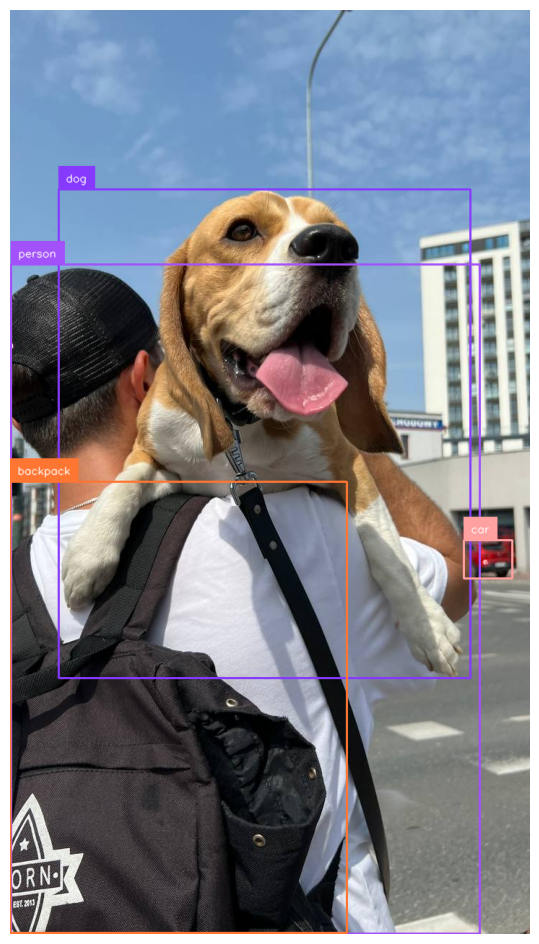

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="zaFOcSSyUyXqzWgj3MZV")
project = rf.workspace("fastnuces-uakqb").project("fyp-shoplift")
version = project.version(21)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FYP-Shoplift-21 in yolov12:: 100%|██████████| 10110/10110 [00:02<00:00, 4514.61it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['normal', 'shoplifting']

roboflow:
  workspace: fastnuces-uakqb
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=70)

New https://pypi.org/project/ultralytics/8.3.191 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/FYP-Shoplift-21/data.yaml, epochs=70, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

100%|██████████| 755k/755k [00:00<00:00, 27.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/FYP-Shoplift-21/train/labels... 3717 images, 100 backgrounds, 0 corrupt: 100%|██████████| 3717/3717 [00:01<00:00, 2259.87it/s]


train: New cache created: /content/FYP-Shoplift-21/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1381, len(boxes) = 6538. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/FYP-Shoplift-21/valid/labels... 918 images, 18 backgrounds, 0 corrupt: 100%|██████████| 918/918 [00:01<00:00, 841.80it/s]


val: New cache created: /content/FYP-Shoplift-21/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 588, len(boxes) = 1729. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      6.81G       3.09      3.777      3.675         16        640: 100%|██████████| 233/233 [02:28<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


                   all        918       1729     0.0766      0.273     0.0309     0.0101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      6.94G      2.458      2.744      2.794         15        640: 100%|██████████| 233/233 [02:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.35it/s]

                   all        918       1729      0.324      0.369      0.257      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      6.77G      2.147      2.349      2.471         33        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.20it/s]

                   all        918       1729      0.231      0.396      0.241      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      6.75G      1.935      2.068      2.252         16        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.41it/s]

                   all        918       1729      0.491      0.506      0.422      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      6.77G      1.791      1.852      2.104         10        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]

                   all        918       1729      0.462      0.499      0.424       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      6.92G      1.718      1.786      2.039         17        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]

                   all        918       1729        0.5       0.55      0.432      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      6.95G      1.649      1.689      1.955         12        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

                   all        918       1729      0.467      0.587      0.457       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      6.89G      1.593       1.61      1.907         13        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        918       1729      0.392      0.678      0.449      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      6.77G      1.568      1.565       1.88         31        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.33it/s]

                   all        918       1729       0.41      0.693      0.484      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      6.92G      1.516      1.511      1.836         12        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]

                   all        918       1729      0.462      0.684      0.506      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      6.92G      1.475      1.479      1.809         14        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.50it/s]

                   all        918       1729      0.483      0.694      0.529      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      6.72G      1.457      1.466      1.779         21        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.505      0.697      0.557      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      6.78G      1.425      1.411      1.754         23        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.50it/s]

                   all        918       1729      0.495      0.676       0.53      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      6.94G        1.4      1.383      1.732         16        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.22it/s]

                   all        918       1729      0.522      0.694      0.569      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      6.92G      1.391      1.349      1.734         20        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]

                   all        918       1729      0.512      0.737      0.567      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      6.74G      1.365      1.351      1.707         12        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]

                   all        918       1729      0.529      0.709      0.565      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      6.76G      1.348       1.33      1.681         20        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.26it/s]

                   all        918       1729      0.575      0.695      0.594      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      6.77G      1.334       1.31      1.681         20        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.33it/s]

                   all        918       1729      0.544       0.69      0.568       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      6.92G      1.311      1.283       1.65         11        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.29it/s]

                   all        918       1729      0.534       0.73      0.597      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      6.91G      1.298      1.263      1.637         12        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.52it/s]

                   all        918       1729      0.516      0.692      0.572      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      6.92G       1.29      1.263       1.63         13        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.554      0.709      0.589      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      6.94G      1.276      1.228      1.617         24        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]

                   all        918       1729      0.544      0.694      0.588      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      6.92G      1.267      1.216       1.61         15        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.42it/s]

                   all        918       1729      0.538      0.758      0.618      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      6.72G      1.239      1.206      1.592         16        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.32it/s]

                   all        918       1729      0.556      0.704      0.635      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      6.76G      1.242      1.208      1.591          9        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.51it/s]

                   all        918       1729      0.532      0.743      0.619      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      6.94G       1.24      1.189       1.59         21        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.554      0.727      0.613      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      6.94G      1.219      1.185      1.567         13        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.35it/s]

                   all        918       1729      0.547      0.771      0.617       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      6.88G      1.213      1.165       1.56         17        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        918       1729      0.531      0.736       0.59       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      6.93G      1.201      1.162      1.549         24        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.22it/s]

                   all        918       1729      0.543      0.732      0.613      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      6.91G      1.199      1.157      1.562         26        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]

                   all        918       1729       0.56       0.76      0.651      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      6.92G      1.186       1.14      1.539         17        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.555      0.778       0.66      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      6.72G       1.19      1.133      1.534         22        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]

                   all        918       1729      0.525      0.741      0.601      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      6.76G      1.166       1.14      1.523         26        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.33it/s]

                   all        918       1729      0.572      0.707      0.644      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      6.91G      1.164      1.104      1.509         22        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.39it/s]

                   all        918       1729      0.587      0.698      0.668      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      6.93G      1.152      1.111      1.512         10        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.21it/s]

                   all        918       1729      0.528      0.795       0.64      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70       6.9G      1.156      1.121      1.511         20        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.30it/s]

                   all        918       1729      0.551      0.762      0.652      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      6.91G      1.141      1.108      1.501         11        640: 100%|██████████| 233/233 [02:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.26it/s]

                   all        918       1729      0.568      0.729      0.658      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      6.95G      1.125      1.092      1.489          9        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.24it/s]

                   all        918       1729      0.561      0.725       0.66      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      6.94G      1.129      1.095       1.49         24        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.38it/s]

                   all        918       1729      0.577      0.754      0.693      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      6.72G      1.113      1.069      1.475         15        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.593      0.701      0.693      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      6.78G      1.111      1.069      1.476         23        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.53it/s]

                   all        918       1729      0.569      0.756      0.671      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      6.91G      1.115      1.076      1.472         18        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]

                   all        918       1729      0.601       0.74      0.714      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      6.93G      1.096       1.06      1.467         15        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.50it/s]

                   all        918       1729      0.591       0.69      0.695      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      6.88G      1.076      1.048      1.445         16        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.28it/s]

                   all        918       1729      0.597      0.731      0.693      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      6.91G      1.084      1.041      1.442         10        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.37it/s]

                   all        918       1729      0.561      0.793      0.721      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      6.94G      1.089      1.049      1.458         15        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.28it/s]

                   all        918       1729      0.639       0.69      0.723      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      6.78G      1.064      1.028      1.433         23        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.30it/s]

                   all        918       1729      0.589      0.773      0.718      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      6.91G      1.066      1.023      1.435         15        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.53it/s]

                   all        918       1729        0.6      0.716      0.707      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      6.93G      1.069      1.028      1.443         27        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]

                   all        918       1729        0.6      0.709      0.697       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      6.75G       1.06      1.022      1.433         18        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.52it/s]

                   all        918       1729      0.596       0.73      0.725      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      6.93G       1.05      1.021      1.419         18        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.28it/s]

                   all        918       1729      0.582      0.778      0.719       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70       6.9G      1.043      1.006      1.416         20        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.24it/s]

                   all        918       1729      0.607      0.714      0.719      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      6.92G      1.038      1.006      1.417         16        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.32it/s]

                   all        918       1729      0.629      0.705      0.715      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      6.92G      1.038     0.9867      1.419         15        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]

                   all        918       1729      0.562      0.847      0.737      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      6.95G      1.025     0.9983      1.401         17        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.53it/s]

                   all        918       1729      0.649      0.679      0.734      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      6.91G      1.022       0.98      1.399         19        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]

                   all        918       1729      0.556      0.824      0.729      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      6.93G      1.008     0.9664       1.39         17        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.46it/s]

                   all        918       1729      0.595      0.782      0.747      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      6.94G      1.002     0.9863      1.388         14        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        918       1729       0.62      0.758       0.74      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      6.92G      1.004      0.971      1.383         18        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        918       1729      0.656      0.699      0.743      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      6.88G     0.9965     0.9537      1.375         15        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.598      0.796      0.739      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      6.91G     0.9333     0.8661      1.371         11        640: 100%|██████████| 233/233 [02:03<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.29it/s]

                   all        918       1729      0.646      0.737      0.758      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      6.75G     0.9211     0.8395      1.361         10        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.42it/s]

                   all        918       1729      0.615      0.774      0.762      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      6.91G      0.899      0.829       1.34          4        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.27it/s]

                   all        918       1729      0.618      0.823      0.777      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      6.88G     0.8997     0.8267      1.345          5        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]

                   all        918       1729      0.711      0.685      0.782      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      6.91G     0.8894      0.809      1.325          7        640: 100%|██████████| 233/233 [02:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.22it/s]

                   all        918       1729      0.623      0.819      0.783      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      6.91G     0.8764     0.8003      1.322          4        640: 100%|██████████| 233/233 [02:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.26it/s]

                   all        918       1729       0.62      0.828      0.781      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      6.92G       0.87     0.8014      1.313          9        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.32it/s]

                   all        918       1729      0.645      0.782      0.781      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      6.88G     0.8734     0.7995      1.316          8        640: 100%|██████████| 233/233 [02:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]

                   all        918       1729      0.609       0.85      0.778      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      6.91G     0.8594     0.7924      1.308          4        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.46it/s]

                   all        918       1729      0.615      0.831      0.784      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      6.92G       0.85      0.786      1.297         12        640: 100%|██████████| 233/233 [02:02<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.20it/s]

                   all        918       1729      0.625      0.824       0.79      0.585



70 epochs completed in 2.585 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.70it/s]


                   all        918       1729      0.624      0.824       0.79      0.585
                normal        680       1453      0.672      0.822      0.806      0.572
           shoplifting        276        276      0.575      0.826      0.774      0.599
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch13980.jpg
confusion_matrix_normalized.png			   train_batch13981.jpg
confusion_matrix.png				   train_batch13982.jpg
events.out.tfevents.1756781724.e414a0d69c58.436.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


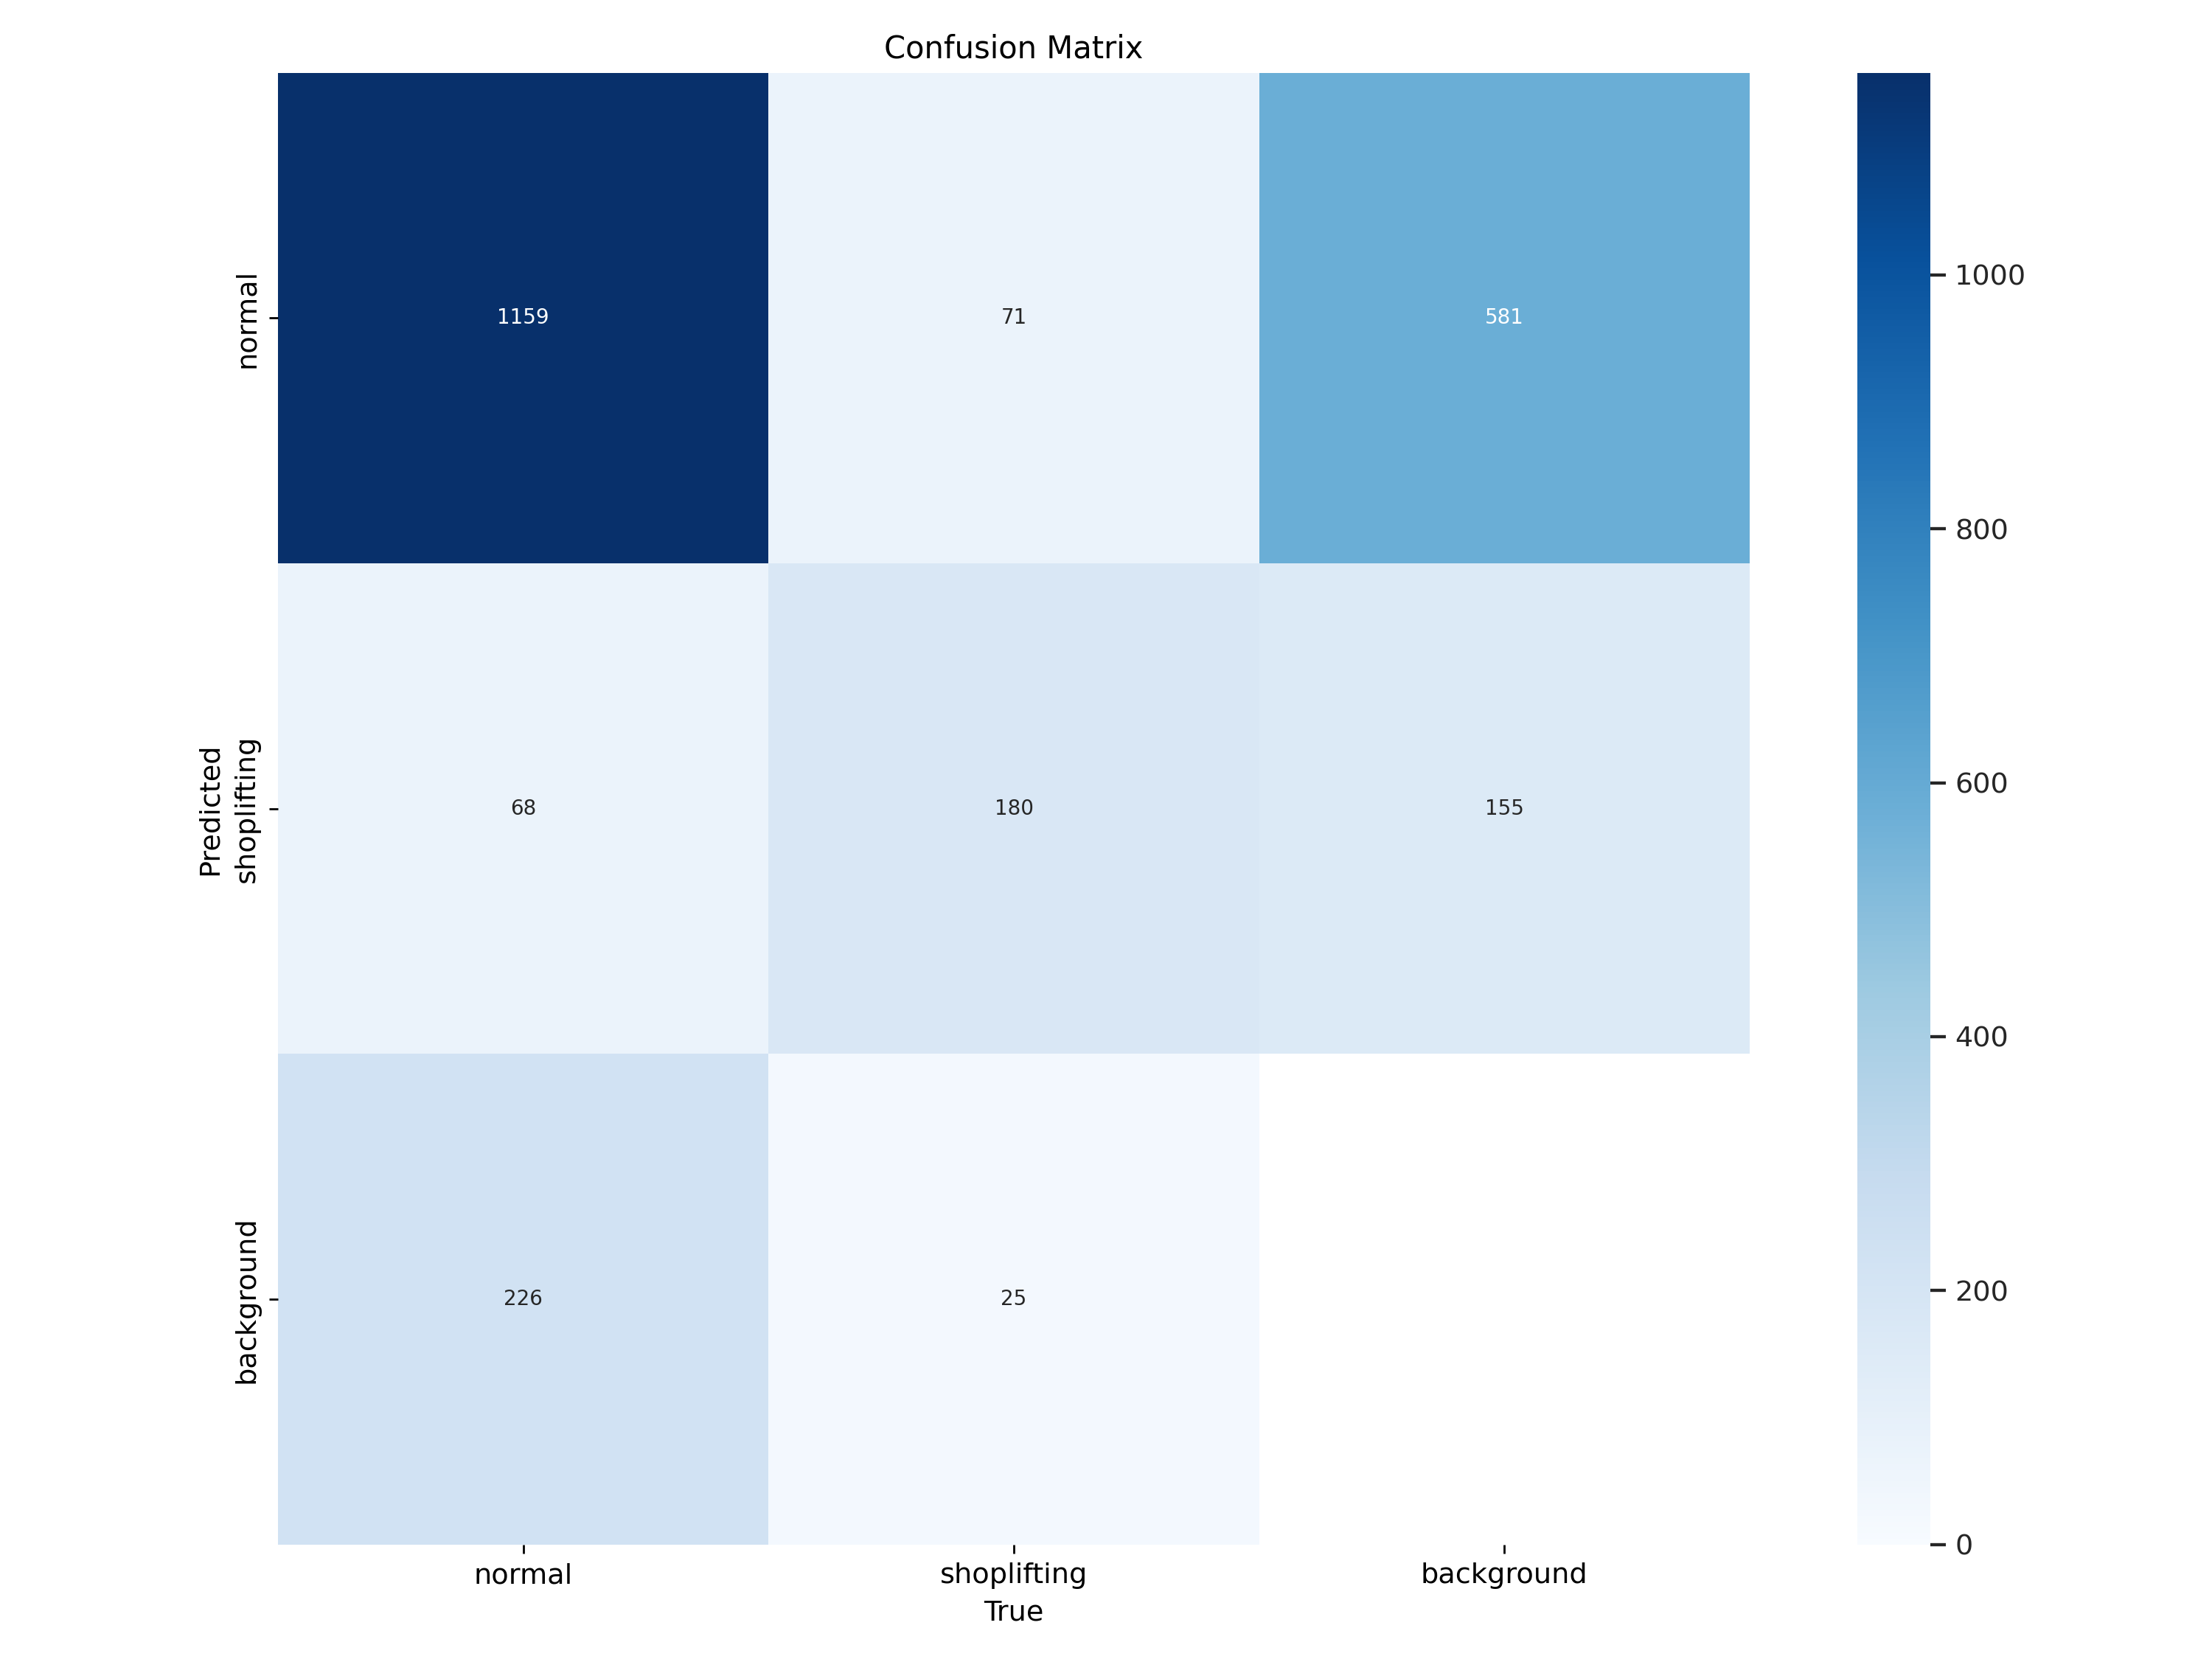

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

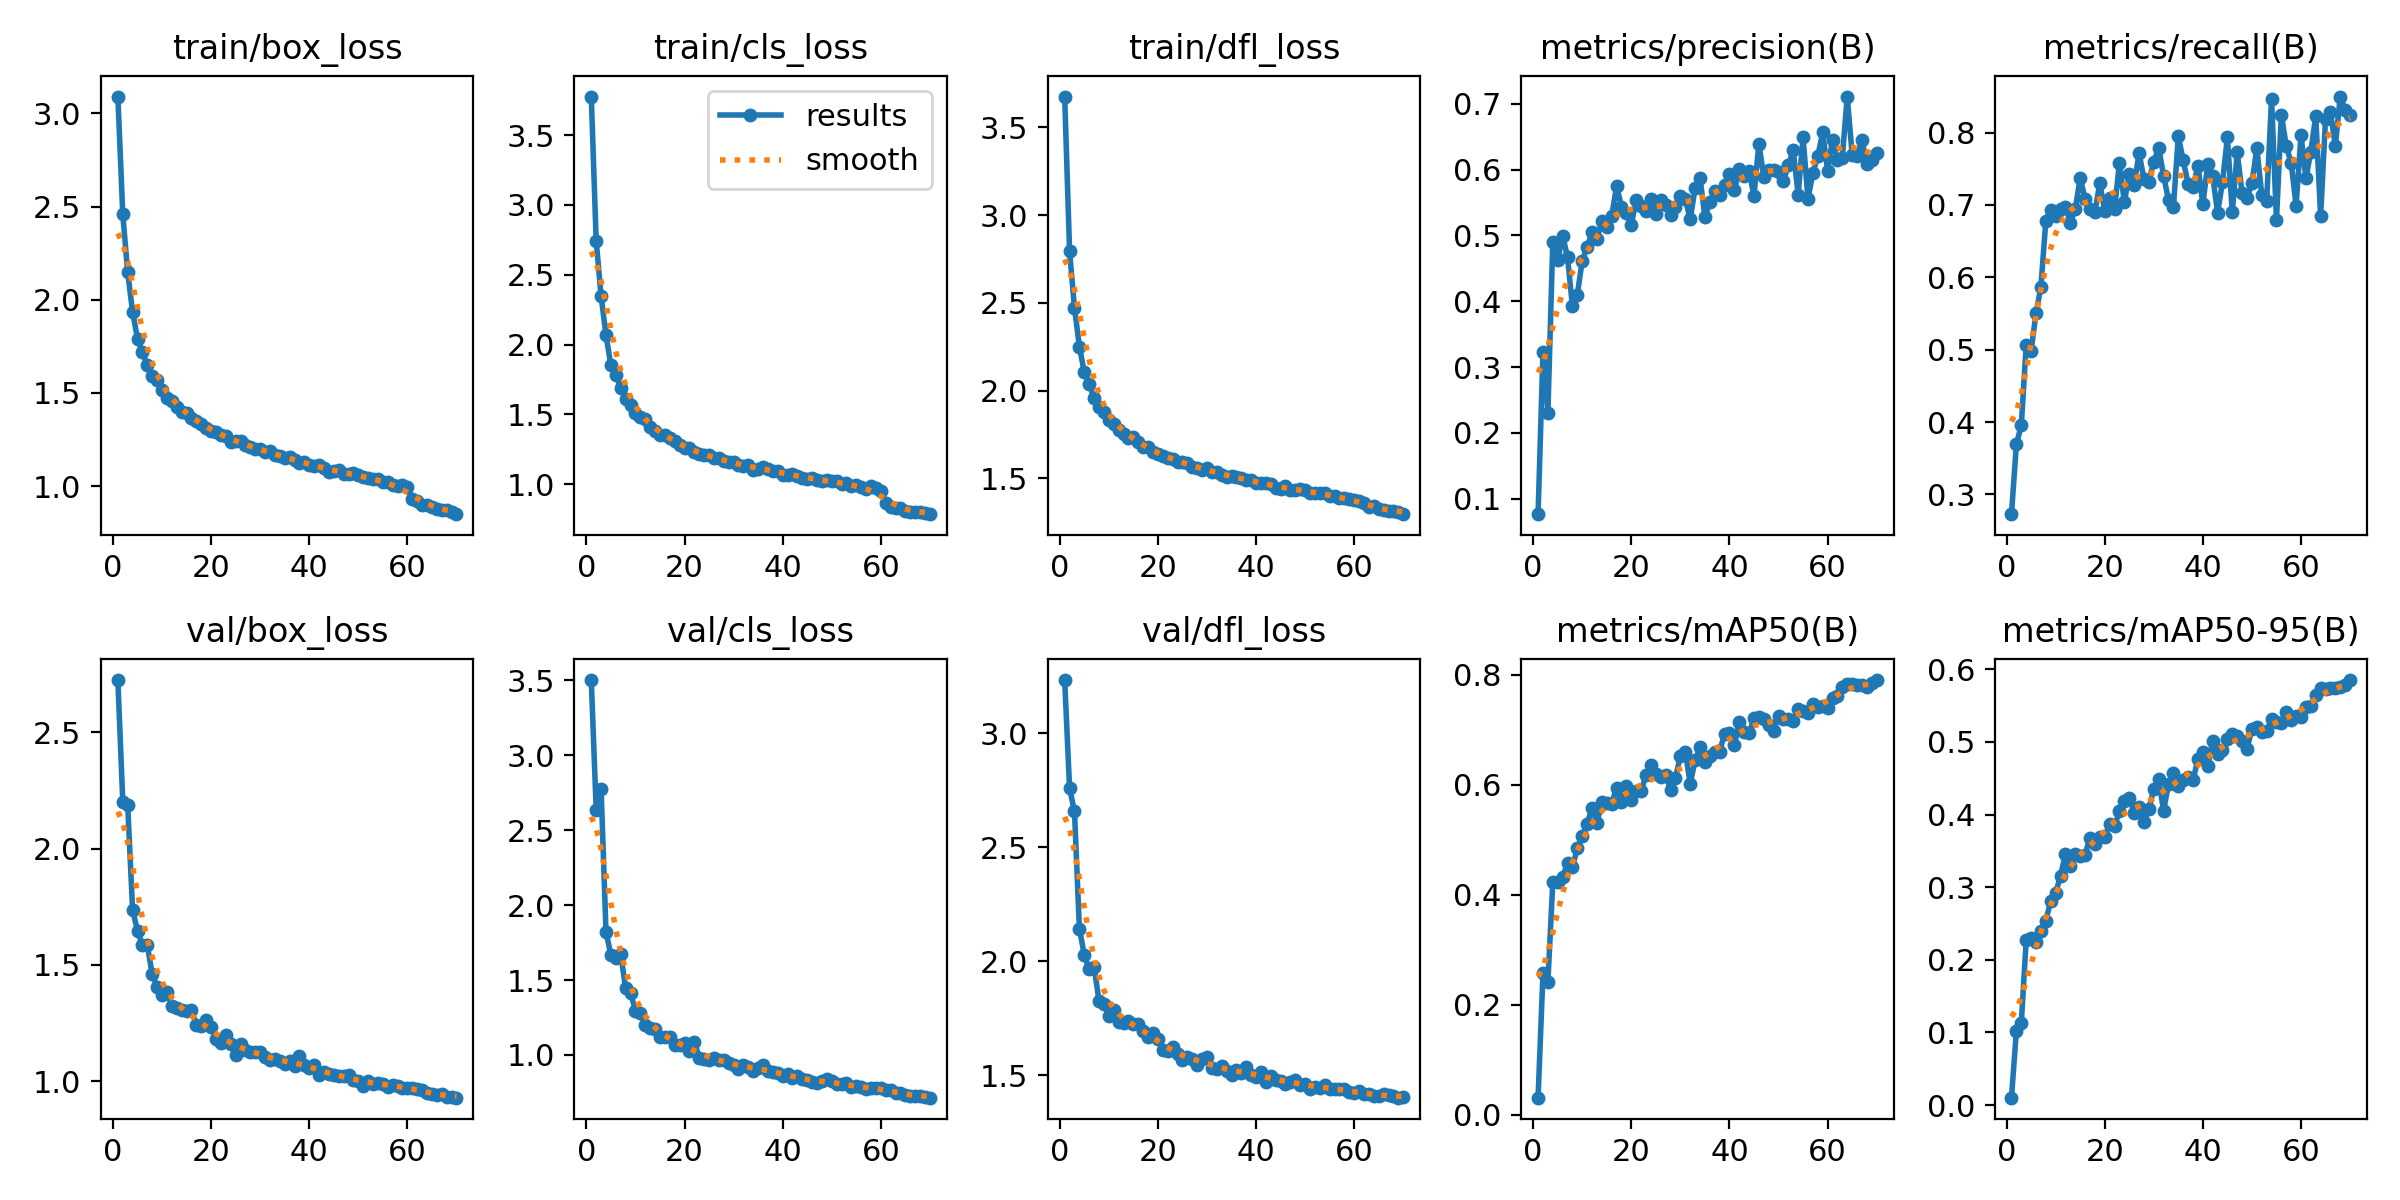

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.25713788517019265
mAP 50 0.42341056357439927
mAP 75 0.2504746197859667


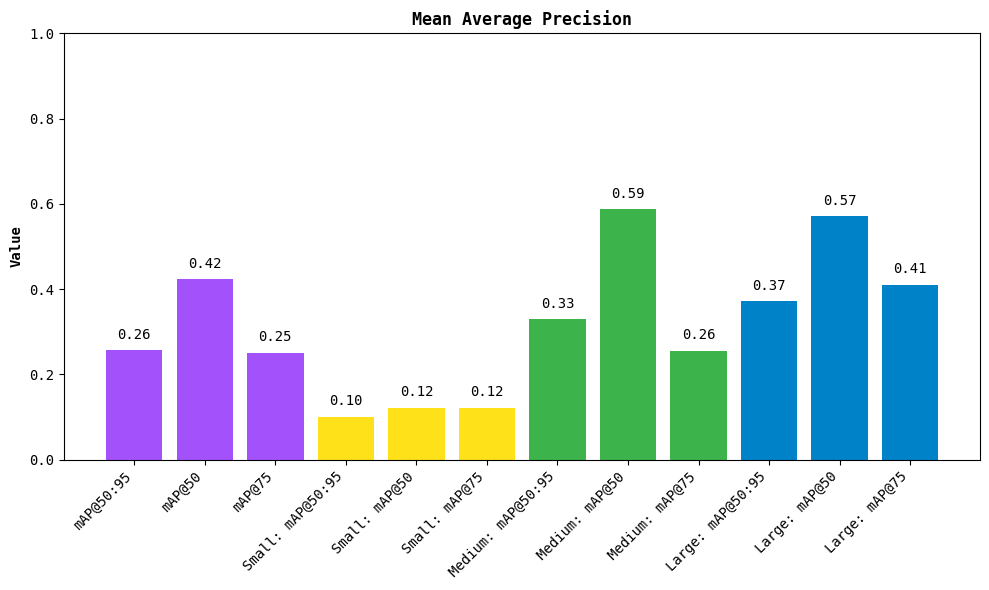

In [18]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [19]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

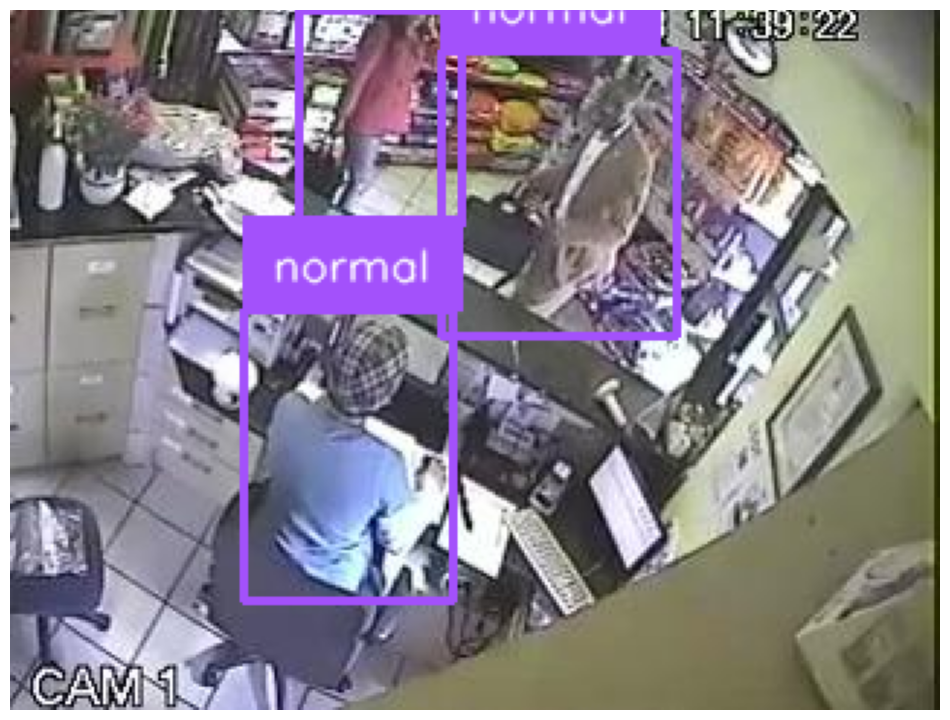

In [28]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)